# AMPSphere v.2022-03

This is a notebook meant to form the set of notebooks used to analyze the data in AMPSphere and write the manuscript:

__AMPSphere: Global survey of prokaryotic antimicrobial peptides shaping microbiomes__

### Check the c_AMP density of species through different environments comparing host-associated and environmental samples

In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib as mpl
import matplotlib.pyplot as plt

from matplotlib import cm
from scipy.stats import kruskal, mannwhitneyu

In [2]:
df = pd.read_table('../data_folder/species_amp_density_per_sample_hq.tsv.gz',
                   sep='\t',
                   header='infer')

df2 = pd.read_table('../data_folder/species_amp_density_crossenvironment_hq.tsv.gz',
                   sep='\t',
                   header='infer')

habitats = {'cat gut': (14/255, 110/255, 168/255, 100/255),
            'human gut': (208/255, 94/255, 21/255, 100/255),
            'dog gut': (70/255, 147/255, 66/255, 100/255),
            'pig gut': (134/255, 189/255, 222/255, 100/255),
            'wastewater': (112/255, 107/255, 170/255, 100/255)}

## Figure S5D

In [3]:
m = df[(df.name == 'Prevotella copri') & (df.general_envo_name.isin(habitats.keys()))]

# sampling procedure
ss = m.general_envo_name.value_counts().min()
newm = pd.DataFrame()
for i in set(m.general_envo_name):
    newdf = m[m.general_envo_name == i].sample(ss)
    newm = pd.concat([newm, newdf])

x = m.groupby('general_envo_name').apply(lambda x: x.amp_density.tolist())
kruskal(*x.tolist())
_, p = kruskal(*x.tolist())
print(f'Kruskal-Walis: p-value = {p}')

Kruskal-Walis: p-value = 1.3973023744969035e-274


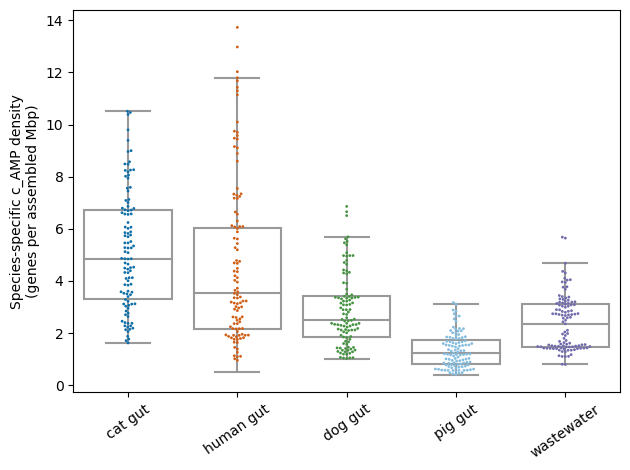

In [4]:
sns.boxplot(data=m,
            x='general_envo_name',
            y='amp_density',
            showfliers=False,
            color='white',
            order=['cat gut',
                   'human gut',
                   'dog gut',
                   'pig gut',
                   'wastewater'])

sns.swarmplot(data=newm,
              x='general_envo_name',
              y='amp_density',
              s=2,
              order=['cat gut',
                     'human gut',
                     'dog gut',
                     'pig gut',
                     'wastewater'],
              palette=habitats)

plt.ylabel('Species-specific c_AMP density\n(genes per assembled Mbp)')
plt.xlabel('')
plt.xticks(rotation=35)
plt.tight_layout()
plt.savefig('Prevotella_ampdensity_guts.svg')
plt.show()

## Figure S5E

In [5]:
habitats = ['human mouth', 'human gut']

t = df2.loc[df2.env1.isin(habitats) & df2.env2.isin(habitats) & (df2.p_adj < 0.05),
          ['species', 'env1', 'env2', 'amp_density_avg_e1', 'amp_density_avg_e2', 'p_adj']]

t = t.reset_index(drop=True)

t['fold'] = t.amp_density_avg_e1 / t.amp_density_avg_e2
t['foldlog'] = np.log10(t.fold)
t['logp'] = np.abs(np.log10(t.p_adj))

t = pd.concat([t[['species',
                  'env1',
                  'amp_density_avg_e1',
                  'foldlog',
                  'logp']].rename({'env1': 'env',
                                   'amp_density_avg_e1': 'amp_density'},
                                   axis=1),
               t[['species',
                  'env2',
                  'amp_density_avg_e2',
                  'foldlog',
                  'logp']].rename({'env2': 'env',
                                   'amp_density_avg_e2': 'amp_density'},
                                   axis=1)])

t.amp_density /= 1000

In [6]:
print('calculate significance')
L = len(t) / 2
nL = len(t[t.foldlog < 1]) / 2
_, p = mannwhitneyu(t.loc[t.env == 'human gut', 'amp_density'],
                    t.loc[t.env == 'human mouth', 'amp_density'])

print('create palette')
cmap = cm.YlOrBr
norm = mpl.colors.Normalize(vmin=t.logp.min(),
                            vmax=t.logp.max())

colors = {s: tuple(cmap(norm(v))) for _, s, v in t[['species', 'logp']].itertuples()}

calculate significance
create palette


plotting
save figure


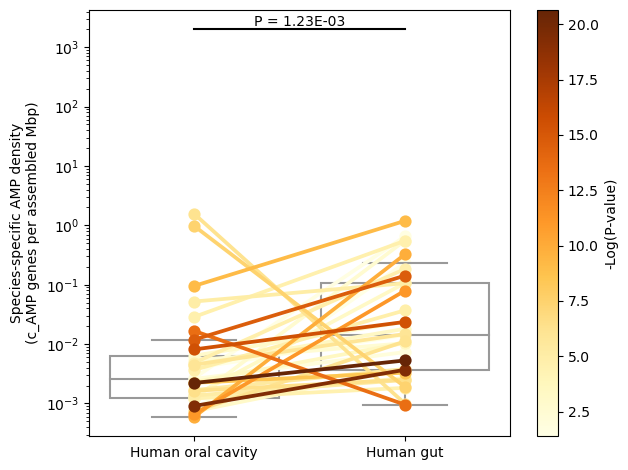

In [7]:
print('plotting')
fig, ax = plt.subplots()

sns.pointplot(ax=ax,
              data=t.sort_values(by='logp'),
              x='env',
              y='amp_density',
              hue='species',
              order=['human mouth', 'human gut'],
              legend=False,
              palette=colors,
              s=1.5,
              kind='point')

sns.boxplot(ax=ax,
            data=t,
            x='env',
            y='amp_density',
            color='white',
            showfliers=False,
            order=['human mouth', 'human gut'])

lx, ly = [0, 2000]
rx, ry = [1, 2000]
ax_y0, ax_y1 = plt.gca().get_ylim()
dh = 0.05 * (ax_y1 - ax_y0)
barh = 0.05 * (ax_y1 - ax_y0)
y = max(ly, ry) + dh
barx = [lx, lx, rx, rx]
bary = [y, y+barh, y+barh, y]
mid = ((lx+rx)/2, y+barh)
ax.plot(barx, bary, c='black')
kwargs = dict(ha='center', va='bottom')
ax.text(*mid,
         f'P = {p:.2E}',
         **kwargs)

ax.get_legend().remove()
ax.set_ylabel('Species-specific AMP density\n(c_AMP genes per assembled Mbp)')
ax.set_xlabel('')
ax.set_yscale('log')
ax.set_xticks([0, 1], ['Human oral cavity', 'Human gut'])

plt.colorbar(mpl.cm.ScalarMappable(norm=norm, cmap=cmap),
             orientation='vertical',
             label='-Log(P-value)')

print("save figure")
plt.tight_layout()
plt.savefig('species_ampdensity_human_mouth_vs_gut.svg')
plt.show()

## Figure S5F

In [8]:
habitats = ['soil', 'plant associated']

t = df2.loc[df2.env1.isin(habitats) & df2.env2.isin(habitats) & (df2.p_adj < 0.05),
          ['species', 'env1', 'env2', 'amp_density_avg_e1', 'amp_density_avg_e2', 'p_adj']]

t = t.reset_index(drop=True)

t['fold'] = t.amp_density_avg_e1 / t.amp_density_avg_e2
t['foldlog'] = np.log10(t.fold)
t['logp'] = np.abs(np.log10(t.p_adj))

t = pd.concat([t[['species',
                  'env1',
                  'amp_density_avg_e1',
                  'foldlog',
                  'logp']].rename({'env1': 'env',
                                   'amp_density_avg_e1': 'amp_density'},
                                   axis=1),
               t[['species',
                  'env2',
                  'amp_density_avg_e2',
                  'foldlog',
                  'logp']].rename({'env2': 'env',
                                   'amp_density_avg_e2': 'amp_density'},
                                   axis=1)])

t.amp_density /= 1000

print('calculate significance')
L = len(t) / 2
nL = len(t[t.foldlog < 1]) / 2
_, p = mannwhitneyu(t.loc[t.env == 'plant associated', 'amp_density'],
                    t.loc[t.env == 'soil', 'amp_density'])

calculate significance


In [9]:
print('create palette')
cmap = cm.YlOrBr
norm = mpl.colors.Normalize(vmin=t.logp.min(),
                            vmax=t.logp.max())

colors = {s: tuple(cmap(norm(v))) for _, s, v in t[['species', 'logp']].itertuples()}

create palette


plotting
save figure


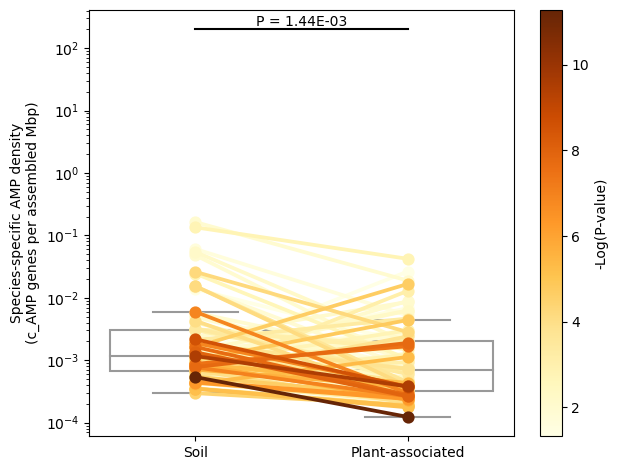

In [10]:
print('plotting')
fig, ax = plt.subplots()

sns.pointplot(ax=ax,
              data=t.sort_values(by='logp'),
              x='env',
              y='amp_density',
              hue='species',
              order=['soil', 'plant associated'],
              legend=False,
              palette=colors,
              s=1.5,
              kind='point')

sns.boxplot(ax=ax,
            data=t,
            x='env',
            y='amp_density',
            color='white',
            showfliers=False,
            order=['soil', 'plant associated'])

lx, ly = [0, 200]
rx, ry = [1, 200]
ax_y0, ax_y1 = plt.gca().get_ylim()
dh = 0.05 * (ax_y1 - ax_y0)
barh = 0.05 * (ax_y1 - ax_y0)
y = max(ly, ry) + dh
barx = [lx, lx, rx, rx]
bary = [y, y+barh, y+barh, y]
mid = ((lx+rx)/2, y+barh)
ax.plot(barx, bary, c='black')
kwargs = dict(ha='center', va='bottom')
ax.text(*mid,
         f'P = {p:.2E}',
         **kwargs)

ax.get_legend().remove()
ax.set_ylabel('Species-specific AMP density\n(c_AMP genes per assembled Mbp)')
ax.set_xlabel('')
ax.set_yscale('log')
ax.set_xticks([0, 1], ['Soil', 'Plant-associated'])

plt.colorbar(mpl.cm.ScalarMappable(norm=norm, cmap=cmap),
             orientation='vertical',
             label='-Log(P-value)')

print("save figure")
plt.tight_layout()
plt.savefig('species_ampdensity_plant_soil.svg')
plt.show()